In [1]:
import warnings
warnings.filterwarnings("ignore")

In [2]:
import pandas as pd 
import csv
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import re


## à extraire de ce champ commentaire pour en faire de nouveaux :

    présence d'allergène
    dosage min
    dosage max
    novel food (booléan) si oui, date d'entrée dans le catalogue et URL vers texte en question
    avertissements à mentionner sur l'étiquette
    avertissements sur les populations cibles
    avis ANSES et URL vers le lien de l'avis; sa date; les mises à jour
    avis EMA
    les synonymes (déjà présent dans la base, mais alimenter ce champ à partir des infos contenues dans comm)


In [3]:
INGREDIENTS = {
    "REF_ICA_INGREDIENT_AUTRE.csv",
    "REF_ICA_MICRO_ORGANISME.csv",
    "REF_ICA_PLANTE.csv",
    "REF_ICA_SUBSTANCE_ACTIVE.csv",
}

In [4]:
ingredient_df = pd.read_csv('../raw_data/REF_ICA_INGREDIENT_AUTRE.csv')
ingredient_df['INGA_COMMENTAIRE_PUBLIC']

0                                                     NaN
1                                                     NaN
2                                                     NaN
3                                                     NaN
4                                                     NaN
                              ...                        
1166                                                  NaN
1167    La quantité de chondroïtine par dose journaliè...
1168                                                  NaN
1169                                                  NaN
1170                                                  NaN
Name: INGA_COMMENTAIRE_PUBLIC, Length: 1171, dtype: object

In [5]:
# Merge des DF de tous les types d'ingrédients

columns_to_select = ['COMMENTAIRE_PUBLIC', 'COMMENTAIRE_PUBLIC_EN']
df_list = []
for filename in INGREDIENTS:
    df = pd.read_csv(f'../raw_data/{filename}')
    columns = [column_name for column_name in df.columns if column_name.split('_', 1)[1] in columns_to_select]
    df = df[columns]
    ingr_type = df.columns[0].split('_')[0]
    df.columns = columns_to_select
    df['TYPE'] = ingr_type
    df_list.append(df)

all_ingredient_df = pd.concat(df_list)
all_ingredient_df

,COMMENTAIRE_PUBLIC,COMMENTAIRE_PUBLIC_EN,TYPE
0,Enfants de moins de 10 ans : 200 µg Adolescent...,NaN,SBSACT
1,NaN,NaN,SBSACT
2,NaN,NaN,SBSACT
3,Enfants de moins de 10 ans : 100 µg Adolescent...,NaN,SBSACT
4,Enfants de moins de 10 ans : 25 µg Adolescents...,NaN,SBSACT
...,...,...,...
86,NaN,NaN,MORG
87,NaN,NaN,MORG
88,NaN,NaN,MORG
89,NaN,NaN,MORG


In [6]:
# Regexp AVIS Anses/EMA

def contains_elements_to_find(comment, elements_to_find):
    if pd.isnull(comment):
        return np.nan
    if any(elem for elem in elements_to_find  if comment.lower().find(elem) != -1):
        return True
    else:
        return False

ingredient_df['contains_ANSES'] = ingredient_df['INGA_COMMENTAIRE_PUBLIC'].apply(lambda x: contains_elements_to_find(x, ['anses']))
ingredient_df[ingredient_df['contains_ANSES'] == True]['INGA_COMMENTAIRE_PUBLIC']

228     L’Anses, dans son avis du 4 janvier 2019 (http...
291     La quantité de mélatonine par dose journalière...
296     L’Anses, dans son avis du 4 janvier 2019 (http...
339     La quantité de chondroïtine par dose journaliè...
340     La quantité de glucosamine par dose journalièr...
825     La quantité de glucosamine par dose journalièr...
1167    La quantité de chondroïtine par dose journaliè...
Name: INGA_COMMENTAIRE_PUBLIC, dtype: object

In [7]:
all_ingredient_df['contains_ANSES'] = all_ingredient_df['COMMENTAIRE_PUBLIC'].apply(lambda x: contains_elements_to_find(x, ['anses']))
len(all_ingredient_df[all_ingredient_df['contains_ANSES'] == True][['COMMENTAIRE_PUBLIC', 'TYPE']])

72

In [8]:
   
all_ingredient_df['contains_HTTP'] = all_ingredient_df['COMMENTAIRE_PUBLIC'].apply(lambda x : contains_elements_to_find(x, ["http://", "https://"]))
len(all_ingredient_df[all_ingredient_df['contains_HTTP'] == True][['COMMENTAIRE_PUBLIC', 'TYPE']])

29

In [9]:
   
all_ingredient_df['contains_EMA'] = all_ingredient_df['COMMENTAIRE_PUBLIC'].apply(lambda x : contains_elements_to_find(x, ["ema"]))
len(all_ingredient_df[all_ingredient_df['contains_EMA'] == True][['COMMENTAIRE_PUBLIC', 'TYPE']])

67

In [10]:
   
all_ingredient_df['contains_allergie'] = all_ingredient_df['COMMENTAIRE_PUBLIC'].apply(lambda x : contains_elements_to_find(x, ["allerg"]))
len(all_ingredient_df[all_ingredient_df['contains_allergie'] == True][['COMMENTAIRE_PUBLIC', 'TYPE']])

38

In [11]:
   
all_ingredient_df['contains_novel_food'] = all_ingredient_df['COMMENTAIRE_PUBLIC'].apply(lambda x : contains_elements_to_find(x, ["novel food"]))
len(all_ingredient_df[all_ingredient_df['contains_novel_food'] == True][['COMMENTAIRE_PUBLIC', 'TYPE']])

53

## Feature engineering

In [12]:
# creation de boolean pour compter le nombre d'apparition des mots dans les commentaires
BOOL_EXPRESSIONS = {
    "contains_ANSES": 'anses',
    "contains_HTTP": 'http',
    "contains_EMA": 'ema',
    "contains_allergie": 'allerg',
    "contains_novel_food": 'novel food|nouvel aliment',
    "contains_femme_enceinte": 'enceinte|enceintes' ,
    "contains_femme_allaitante": 'allaitante|allaitantes',
    "contains_enfant": 'enfants',
    "contains_CI": 'traitement', 
    "contains_avertissement": 'avertissement' 
}
ingredients_with_comments = all_ingredient_df.dropna(subset=['COMMENTAIRE_PUBLIC'])
ingredients_with_comments['COMMENTAIRE_PUBLIC'] = ingredients_with_comments['COMMENTAIRE_PUBLIC'].str.lower()

for condition, expression in BOOL_EXPRESSIONS.items():
    ingredients_with_comments[condition] = ingredients_with_comments['COMMENTAIRE_PUBLIC'].str.count(expression)

ingredients_with_comments.sum(axis=0, numeric_only=True)

contains_ANSES                91
contains_HTTP                 36
contains_EMA                  81
contains_allergie             40
contains_novel_food          114
contains_femme_enceinte      217
contains_femme_allaitante    150
contains_enfant              164
contains_CI                  110
contains_avertissement       102
dtype: int64

In [13]:
pd.set_option('display.max_colwidth', None)
ingredients_with_comments[ingredients_with_comments["contains_HTTP"] == 2][['COMMENTAIRE_PUBLIC']].head()

,COMMENTAIRE_PUBLIC
195,dose de référence pour la toxicité aigüe du delta9-thc (arfd): 1 µg /kg poids corporel. (https://www.efsa.europa.eu/fr/efsajournal/pub/4141) - teneur règlementée par le règlement (ue) 2022/1393 modifiant le règlement(ce) 1881/2006 (https://eur-lex.europa.eu/legal-content/en/txt/?uri=celex%3a32022r1393&amp;qid=1665570031028)
254,règlement (ue) 2021/468 : interdiction d'ajout de cette substance et de toutes les préparations dans lesquelles cette substance est présente. la teneur doit rester strictement inférieure à 1 ppm (1 mg/kg) dans le produit fini prêt à être consommé (https://ec.europa.eu/food/sites/food/files/safety/docs/reg-com_gfl_20201005_sum.pdf). méthodes analytiques : https://www.wur.nl/en/show/1.-eurl-mp-report_002-inventory-analytical-methods-hydroxyanthracene-derivatives.htm - une méthode via hplc-uv permet d'atteindre cette limite de quantification.
255,somme des aloïnes a et b - règlement (ue) 2021/468 : interdiction d'ajout de cette substance et de toutes les préparations dans lesquelles cette substance est présente. la teneur doit rester strictement inférieure à 1 ppm (1 mg/kg) dans le produit fini prêt à être consommé (https://ec.europa.eu/food/sites/food/files/safety/docs/reg-com_gfl_20201005_sum.pdf). méthodes analytiques : https://www.wur.nl/en/show/1.-eurl-mp-report_002-inventory-analytical-methods-hydroxyanthracene-derivatives.htm - une méthode via hplc-uv permet d'atteindre cette limite de quantification.
278,somme des aloïnes a et b - règlement (ue) 2021/468 : interdiction d'ajout de cette substance et de toutes les préparations dans lesquelles cette substance est présente. la teneur doit rester strictement inférieure à 1 ppm (1 mg/kg) dans le produit fini prêt à être consommé (https://ec.europa.eu/food/sites/food/files/safety/docs/reg-com_gfl_20201005_sum.pdf). méthodes analytiques : https://www.wur.nl/en/show/1.-eurl-mp-report_002-inventory-analytical-methods-hydroxyanthracene-derivatives.htm - une méthode via hplc-uv permet d'atteindre cette limite de quantification.
346,règlement (ue) 2021/468 : interdiction d'ajout de cette substance et de toutes les préparations dans lesquelles cette substance est présente. la teneur doit rester strictement inférieure à 1 ppm (1 mg/kg) dans le produit fini prêt à être consommé (https://food.ec.europa.eu/system/files/2020-12/reg-com_gfl_20201005_sum.pdf). méthodes analytiques : https://www.wur.nl/en/show/1.-eurl-mp-report_002-inventory-analytical-methods-hydroxyanthracene-derivatives.htm - une méthode via hplc-uv permet d'atteindre cette limite de quantification.


In [14]:
pd.set_option('display.max_colwidth', 50)

# extraction de contenu dans d'autres colonnes
EXTR_EXPRESSIONS = {

    "url": "(https?:\/\/(?:www\.|(?!www))[a-zA-Z0-9][a-zA-Z0-9-]+[a-zA-Z0-9]\.[^\s]{2,}|www\.[a-zA-Z0-9][a-zA-Z0-9-]+[a-zA-Z0-9]\.[^\s]{2,}|https?:\/\/(?:www\.|(?!www))[a-zA-Z0-9]+\.[^\s]{2,}|www\.[a-zA-Z0-9]+\.[^\s]{2,})",
    "avis anses/ema": "avis\sanses\/ema\s\((.+)\)\s:([^.]+)", #manque anses,?\sdans\sson\savis\sdu\s #certaines liste sont suivies par des .
    "mesure": "(?<!\d|\.)(\d+(?:\.\d+|,\d+)?\s*?(?:kg|g|dg|cg|mg|µg|ng|ml|l|cl|ui|m|ppm)(?:\s*?\/?\s*?(?:kg|g|dg|cg|mg|µg|ng|ml|l|cl|ui|m))?)(?!\w)", #200 ng ou 200ng/kg
    # TODO
    # "anses_url": "https://www.anses.fr/",
    # "novel_food_url": "https://ec.europa.eu/| https://food.ec.europa.eu/ | https://ema.europa.eu/ | https://efsa.europa.eu/",
    # "avertissement": 
    # Enfants de moins de 10 ans : 
    # Adolescents : 
    # Novel Food :
    # Avertissement obligatoire sur l'étiquetage: // L’étiquetage des compléments alimentaires 
    # Maximum : 
}

for condition, expression in EXTR_EXPRESSIONS.items():
    ingredients_with_comments[condition] = ingredients_with_comments['COMMENTAIRE_PUBLIC'].apply(lambda x: re.findall(expression, x, flags=re.IGNORECASE))
    if condition in ['avis anses/ema']:
        ingredients_with_comments['COMMENTAIRE_PUBLIC'] = ingredients_with_comments['COMMENTAIRE_PUBLIC'].apply(lambda x: re.sub(expression, '', x))

ingredients_with_comments

,COMMENTAIRE_PUBLIC,COMMENTAIRE_PUBLIC_EN,TYPE,contains_ANSES,contains_HTTP,contains_EMA,contains_allergie,contains_novel_food,contains_femme_enceinte,contains_femme_allaitante,contains_enfant,contains_CI,contains_avertissement,url,avis anses/ema,mesure
0,enfants de moins de 10 ans : 200 µg adolescent...,NaN,SBSACT,0,0,0,0,0,1,0,2,0,0,[],[],"[200 µg, 500 µg]"
3,enfants de moins de 10 ans : 100 µg adolescent...,NaN,SBSACT,0,0,0,0,0,1,0,2,0,0,[],[],"[100 µg, 250 µg, 800 µg]"
4,enfants de moins de 10 ans : 25 µg adolescents...,NaN,SBSACT,0,0,0,0,0,0,0,2,0,0,[],[],"[25 µg, 50 µg]"
5,l'apport de vitamine k est déconseillé chez le...,NaN,SBSACT,0,0,0,0,0,0,0,0,0,0,[],[],[]
8,enfants de moins de 10 ans : 90 mg pour la nic...,NaN,SBSACT,0,0,0,0,0,0,0,2,0,0,[],[],"[90 mg, 1,6 mg, 225 mg, 4 mg, 450 mg, 8 mg]"
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1150,règ. (ue) n°2022/1373 : dénomination sur l'éti...,NaN,INGA,0,0,0,0,0,0,0,4,0,2,[],[],"[100 mg, 50 mg]"
1153,novel food autorisé - la dénomination du nouve...,NaN,INGA,0,0,0,0,2,1,1,1,0,0,[],[],"[120g, 120 mg]"
1161,seule la poudre de bois d'élan ou bois de velo...,NaN,INGA,0,0,0,0,1,0,0,0,0,0,[],[],[]
1167,la quantité de chondroïtine par dose journaliè...,NaN,INGA,2,1,0,0,0,1,1,1,0,0,[https://www.anses.fr/fr/system/files/nut2015s...,[],[950 mg]


In [15]:
# test regex mesure
exemples = pd.DataFrame({"coucou": ["je prend 2,4g/kg si ça va", "et tu pèses seulement 2.55 mg", "et il faut aussi matcher 400 0     ppm "]})
exemples['coucou'].apply(lambda x: re.findall(EXTR_EXPRESSIONS['mesure'], x, flags=re.IGNORECASE))


0      [2,4g/kg]
1      [2.55 mg]
2    [0     ppm]
Name: coucou, dtype: object

In [16]:
pd.set_option('display.max_colwidth', None)

ingredients_with_comments[ingredients_with_comments["contains_ANSES"] == 1][["COMMENTAIRE_PUBLIC","avis anses/ema"]]

,COMMENTAIRE_PUBLIC,avis anses/ema
76,"la curcumine possède des effets inhibiteurs sur l’agrégation plaquettaire. elle est déconseillée aux personnes sous anti-coagulants. la curcumine inclut le bis-(hydroxy-4- méthoxy-3-phényl)-1,7-heptadiène-1,6-dione-3,5 et ses deux dérivés dérivés déméthoxy, conformément au règlement 432/2012. saisine n° 2019-sa-0111 de l'anses relatif à « l’évaluation des risques liés à la consommation de compléments alimentaires contenant du curcuma » : &quot;l’analyse de l’exposition de la population française à la curcumine par l’alimentation a montré qu’elle reste faible au regard de la dose journalière admissible (dja) établie par l’efsa, hors compléments alimentaires. partant de cette analyse, l’expertise a déterminé que la prise de tels compléments ne soulève pas de préoccupation particulière tant que leur consommation ne constitue pas un apport de plus de 153 mg de curcumine par jour pour un adulte de 60 kg.&quot;",[]
84,"la quantité de glucosamine par dose journalière recommandée doit être inférieure à la dose pharmacologique (1119 mg de glucosamine). l’anses, dans son avis du 4 janvier 2019, a noté que l’expertise conduite a mis en évidence des populations spécifiques pour lesquelles la consommation de compléments alimentaires contenant de la glucosamine présente un risque.ainsi elle déconseille la consommation de compléments alimentaires contenant cette substance aux : (a) personnes diabétiques ou pré-diabétiques, asthmatiques ou traitées par anti-vitamine k ; (b) personnes présentant une allergie alimentaire aux crustacés ou aux insectes ;(c) personnes dont l’alimentation est contrôlée pour le sodium, le potassium ou le calcium, car ces compléments peuvent en être une source importante ; (d) femmes enceintes ou allaitantes et aux enfants",[]
319,"la curcumine possède des effets inhibiteurs sur l’agrégation plaquettaire. elle est déconseillée aux personnes sous anti-coagulants. la curcumine inclut le bis-(hydroxy-4- méthoxy-3-phényl)-1,7-heptadiène-1,6-dione-3,5 et ses deux dérivés dérivés déméthoxy, conformément au règlement 432/2012. saisine n° 2019-sa-0111 de l'anses relatif à « l’évaluation des risques liés à la consommation de compléments alimentaires contenant du curcuma » : &quot;l’analyse de l’exposition de la population française à la curcumine par l’alimentation a montré qu’elle reste faible au regard de la dose journalière admissible (dja) établie par l’efsa, hors compléments alimentaires. partant de cette analyse, l’expertise a déterminé que la prise de tels compléments ne soulève pas de préoccupation particulière tant que leur consommation ne constitue pas un apport de plus de 153 mg de curcumine par jour pour un adulte de 60 kg.&quot;",[]
12,"dès lors qu’une préparation de sureau est mise en œuvre, la teneur en cyanure d’hydrogène (hcn) du produit fini doit être connue et sa présence doit donner lieu à une analyse de risque spécifique. par ailleurs, l’information concernant un complément alimentaire contenant une préparation de fleur de sureau devrait comporter un avertissement visant à éviter que les femmes enceintes ou allaitantes et les enfants ne le consomment ou, à tout le moins, recommander de prendre l’attache d’un professionnel de santé. .","[(fleur, 1) déconseillé aux enfants de moins de 12 ans, femmes enceintes et allaitantes)]"
42,l'emploi est déconseillé chez les personnes sous traitement anticoagulant. . 2) réservé aux adultes. 3) déconseillé aux femmes enceintes ou allaitantes.,"[(bulbe, 1) déconseillé en cas de traitement concomitant par un médicament anti-rétroviral (saquinavir,ritonavir,…))]"
88,". 2) déconseillé en cas d’allergie à d'autres plantes de la famille des apiaceae telles que fenouil, céleri, anis, coriandre, ainsi qu'au pollen de bouleau, ou à l'absinthe. 3) déconseillé aux femmes enceintes ou allaitantes. 4) pour fruit : déconseillé aux enfants de moins de 12 ans ou pour he fruit : réservé aux adultes.","[(fruit ou he du fruit, 1) déconseillé en cas d

In [17]:
ingredients_with_comments.dropna(subset=['url'])

,COMMENTAIRE_PUBLIC,COMMENTAIRE_PUBLIC_EN,TYPE,contains_ANSES,contains_HTTP,contains_EMA,contains_allergie,contains_novel_food,contains_femme_enceinte,contains_femme_allaitante,contains_enfant,contains_CI,contains_avertissement,url,avis anses/ema,mesure
0,"enfants de moins de 10 ans : 200 µg adolescents : 500 µg la supplémentation en vitamines des nourrissons (0-1 an) et des enfants en bas âge (1–3 ans) fait l’objet d’un encadrement médical. tout apport supplémentaire, sans encadrement par un professionnel de santé, présente des risques pour la santé de cette population. le rétinol est déconseillé aux femmes enceintes ou désireuses de l’être, ainsi qu'aux femmes ménopausées",NaN,SBSACT,0,0,0,0,0,1,0,2,0,0,[],[],"[200 µg, 500 µg]"
3,"enfants de moins de 10 ans : 100 µg adolescents : 250 µg la supplémentation en vitamines des nourrissons (0-1 an) et des enfants en bas âge (1–3 ans) fait l’objet d’un encadrement médical. tout apport supplémentaire, sans encadrement par un professionnel de santé, présente des risques pour la santé de cette population. la teneur maximale recommandée en vitamine b9 est portée à 800 µg lorsque le complément alimentaire est destiné spécifiquement aux femmes enceintes ou désireuses de l’être. un avis médical est alors requis.",NaN,SBSACT,0,0,0,0,0,1,0,2,0,0,[],[],"[100 µg, 250 µg, 800 µg]"
4,"enfants de moins de 10 ans : 25 µg adolescents : 50 µg la supplémentation en vitamines des nourrissons (0-1 an) et des enfants en bas âge (1–3 ans) fait l’objet d’un encadrement médical. tout apport supplémentaire, sans encadrement par un professionnel de santé, présente des risques pour la santé de cette population.",NaN,SBSACT,0,0,0,0,0,0,0,2,0,0,[],[],"[25 µg, 50 µg]"
5,l'apport de vitamine k est déconseillé chez les personnes sous anticoagulants.,NaN,SBSACT,0,0,0,0,0,0,0,0,0,0,[],[],[]
8,"enfants de moins de 10 ans : 90 mg pour la nicotinamide / 1,6 mg pour l'acide nicotinique, pour l’hexanicotinate d’inositol ou l'association de ces deux substances ; adolescents : 225 mg pour la nicotinamide / 4 mg pour l'acide nicotinique, pour l’hexanicotinate d’inositol ou l'association de ces deux substances ; adultes : 450 mg pour la nicotinamide / 8 mg pour l'acide nicotinique, pour l’hexanicotinate d’inositol ou l'association de ces deux substances ; la supplémentation en vitamines des nourrissons (0-1 an) et des enfants en bas âge (1–3 ans) fait l’objet d’un encadrement médical. tout apport supplémentaire, sans encadrement par un professionnel de santé, présente des risques pour la santé de cette population.",NaN,SBSACT,0,0,0,0,0,0,0,2,0,0,[],[],"[90 mg, 1,6 mg, 225 mg, 4 mg, 450 mg, 8 mg]"
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1150,"règ. (ue) n°2022/1373 : dénomination sur l'étiquetage : “tartrate-adipate d’hydroxyde de fer (nano)”. uniquement compléments alimentaires sous forme de gélules. compléments alimentaires pour la population adulte : teneur ihat &lt; ou = à 100 mg/ jour &#43; avertissement indiquant que le complément alimentaire ne doit pas être consommé par les enfants et adolescents de moins de 18 ans. compléments alimentaires pour les enfants et adolescents de moins de 18, à l'exclusion des enfants de moins de 4 ans : teneur ihat &lt; ou = à 50 mg/jour &#43; avertissement indiquant que le complément alimentaire ne doit pas être consommé par les enfants de moins de 4 ans.",NaN,INGA,0,0,0,0,0,0,0,4,0,2,[],[],"[100 mg, 50 mg]"
1153,"novel food autorisé - la dénomination du nouvel aliment sur l’étiquetage des denrées alimentaires qui en contiennent est «flavonoïdes issus de glycyrrhiza glabra l.»,un maximum de 120g de flavonoïdes issus de glycyrrhiza glabra peut être présent dans le produit l’étiquetage des denrées alimentaires auxquelles le produit a été ajouté en tant que nouvel ingrédient alimentaire mentionne : ne doit pas être consommé par les femmes enceintes et allaitantes, les enfants et les jeunes adolescents; les personnes prenant des médicaments délivrés sur ordonnance

## Approche non supervisée de clustering des commentaires

In [18]:
# nombre d'occurence par mots
# ajout de stop words
from sklearn.feature_extraction.text import CountVectorizer
from nltk.corpus import stopwords
french_stopwords = list(stopwords.words('french'))

count_vectorizer_without_stopW = CountVectorizer(stop_words=french_stopwords, ngram_range=(1,1))
matrix_without_stopW = count_vectorizer_without_stopW.fit_transform(all_ingredient_df['COMMENTAIRE_PUBLIC'].dropna())
len(count_vectorizer_without_stopW.vocabulary_.items())
 
count_vectorizer = CountVectorizer(ngram_range=(1,1))
matrix = count_vectorizer.fit_transform(all_ingredient_df['COMMENTAIRE_PUBLIC'].dropna())

In [19]:
counts = pd.DataFrame([np.sum(matrix.toarray(), axis=0)],
                      columns=count_vectorizer.get_feature_names_out())
counts
# .sum(axis=0).to_frame().sort_values(by=['0'], ascending=False)

,000,0001,01,011,0111,05,06,10,100,1000000,...,évaporation,évidence,éviter,évitée,éxecution,éxécution,être,œdémateuse,œdémateuses,œuvre
0,1,1,3,1,2,1,1,26,9,1,...,1,7,7,1,1,1,175,1,3,4


In [20]:
counts_without_stopW = pd.DataFrame([np.sum(matrix_without_stopW.toarray(), axis=0)],
                      columns=count_vectorizer_without_stopW.get_feature_names_out())
counts_without_stopW

,000,0001,01,011,0111,05,06,10,100,1000000,...,évaporation,évidence,éviter,évitée,éxecution,éxécution,être,œdémateuse,œdémateuses,œuvre
0,1,1,3,1,2,1,1,26,9,1,...,1,7,7,1,1,1,175,1,3,4


In [21]:
counts.T.sort_values(by=0, ascending=False).head(20)

,0
de,957
la,653
en,581
est,524
les,472
et,325
déconseillé,275
aux,267
des,265
doit,248


In [22]:
counts_without_stopW.T.sort_values(by=0, ascending=False).head(20)

,0
déconseillé,275
doit,248
femmes,227
surveiller,225
emploi,222
enceintes,216
chez,216
concentration,201
être,175
personnes,166


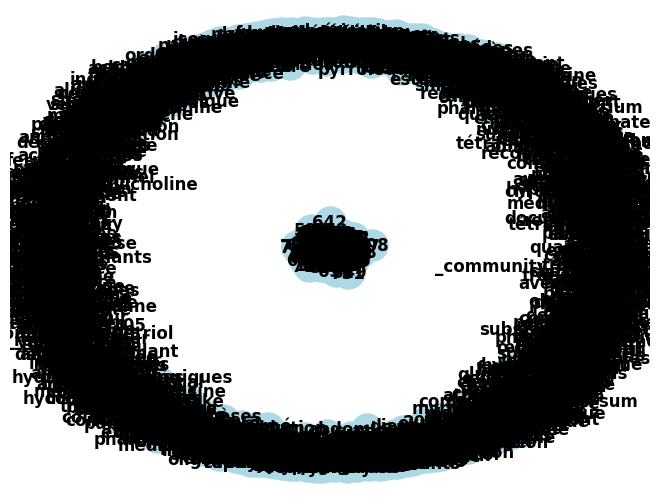

In [23]:
# ça prend 5 minutes de traitement
import networkx as nx
graph = nx.Graph()

num_nodes = len(matrix_without_stopW.toarray())

graph.add_nodes_from(count_vectorizer_without_stopW.get_feature_names_out())
for i in range(num_nodes):
    for j in range(i + 1, num_nodes):
        if matrix_without_stopW.toarray()[i][j] == 1:
            graph.add_edge(i, j)

nx.draw(graph, with_labels=True, node_color='lightblue', node_size=500, font_weight='bold')

plt.show()

In [24]:
# TF-IDF

from sklearn.feature_extraction.text import TfidfTransformer
tfidf = TfidfTransformer(norm="l2")
tfidf.fit(matrix_without_stopW)
tfidf.idf_

tf_idf_matrix = tfidf.transform(matrix_without_stopW)
tf_idf_matrix.todense()

matrix([[0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        ...,
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.]])

In [25]:
matrix_without_stopW.todense()

matrix([[0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        ...,
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0]])

Fit 2 clusters
Fit 6 clusters
Fit 10 clusters
Fit 14 clusters
Fit 18 clusters
Fit 22 clusters
Fit 26 clusters
Fit 30 clusters
Fit 34 clusters
Fit 38 clusters
Fit 42 clusters
Fit 46 clusters
Fit 50 clusters
Fit 54 clusters
Fit 58 clusters
Fit 62 clusters
Fit 66 clusters
Fit 70 clusters
Fit 74 clusters
Fit 78 clusters
Fit 82 clusters
Fit 86 clusters
Fit 90 clusters
Fit 94 clusters
Fit 98 clusters
Fit 102 clusters
Fit 106 clusters
Fit 110 clusters
Fit 114 clusters
Fit 118 clusters
Fit 122 clusters
Fit 126 clusters
Fit 130 clusters
Fit 134 clusters
Fit 138 clusters
Fit 142 clusters
Fit 146 clusters
Fit 150 clusters


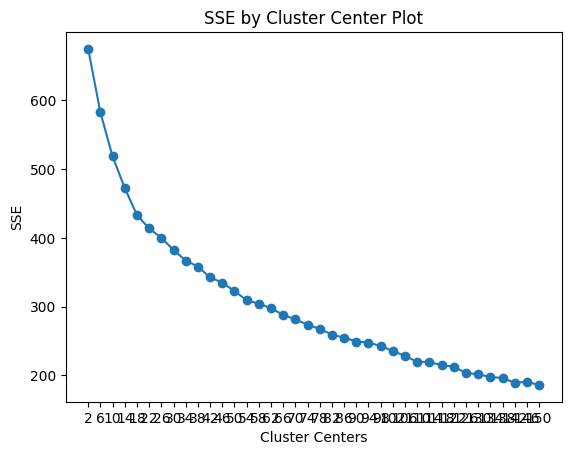

In [26]:
from sklearn.cluster import MiniBatchKMeans

def find_optimal_clusters(data, max_k):
    iters = range(2, max_k+1, 4)
    
    sse = []
    for k in iters:
        sse.append(MiniBatchKMeans(n_clusters=k, init_size=1024, batch_size=2048, random_state=20).fit(data).inertia_)
        print('Fit {} clusters'.format(k))
        
    f, ax = plt.subplots(1, 1)
    ax.plot(iters, sse, marker='o')
    ax.set_xlabel('Cluster Centers')
    ax.set_xticks(iters)
    ax.set_xticklabels(iters)
    ax.set_ylabel('SSE')
    ax.set_title('SSE by Cluster Center Plot')
    
find_optimal_clusters(tf_idf_matrix, 150)

In [27]:
clusters = MiniBatchKMeans(n_clusters=30, init_size=1024, batch_size=2048, random_state=20).fit_predict(tf_idf_matrix)

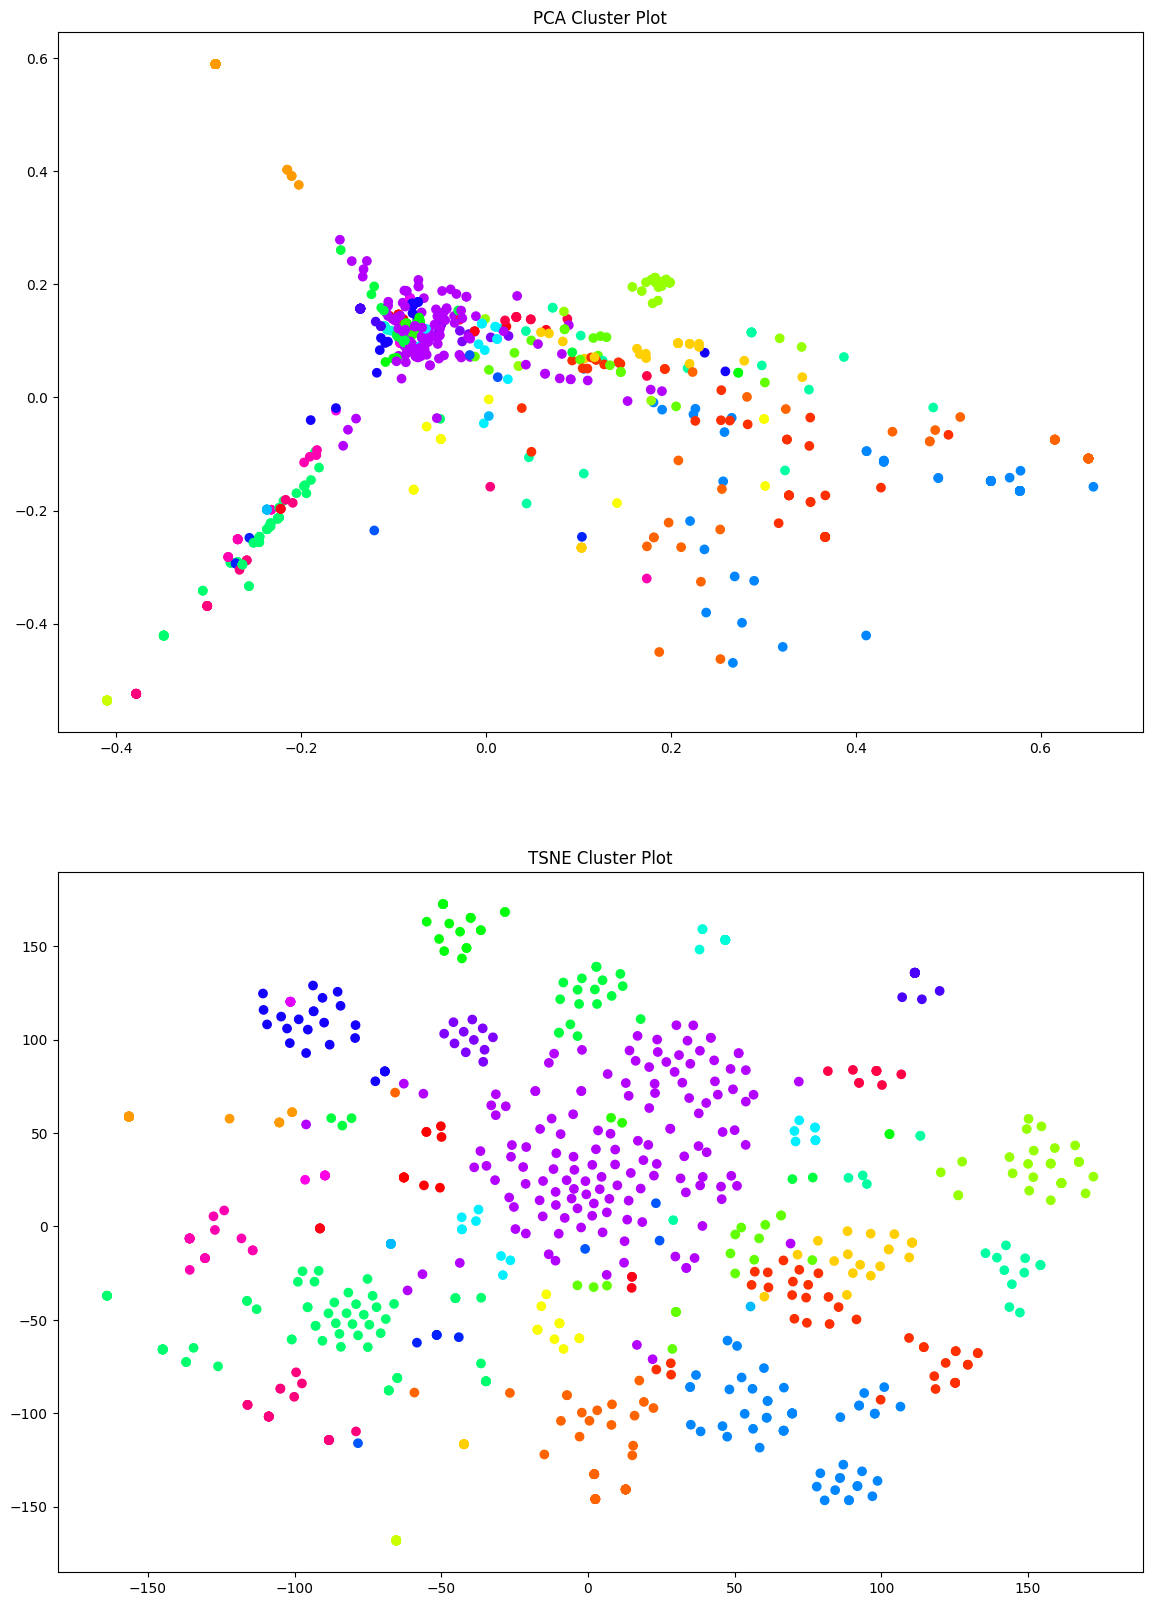

In [36]:
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
import matplotlib.cm as cm

def plot_tsne_pca(data, labels):
    max_label = max(labels)
    
    pca = PCA(n_components=2).fit_transform(np.asarray(data.todense()))
    tsne = TSNE().fit_transform(PCA(n_components=50).fit_transform(np.asarray(data.todense())))
    
    
    idx = np.random.choice(range(pca.shape[0]), size=300, replace=False)
    label_subset = [cm.hsv(i/max_label) for i in labels]
    
    f, ax = plt.subplots(2, 1, figsize=(14, 20))

    ax[0].scatter(pca[:, 0], pca[:, 1], c=label_subset)
    ax[0].set_title('PCA Cluster Plot')
    
    ax[1].scatter(tsne[:, 0], tsne[:, 1], c=label_subset)
    ax[1].set_title('TSNE Cluster Plot')
    # ce ne sont pas les bons labels qui sont affichés
    # for i, txt in enumerate(count_vectorizer_without_stopW.get_feature_names_out()):
        # ax[1].annotate(txt, (tsne[:, 0][i], tsne[:, 1][i]))

    
plot_tsne_pca(tf_idf_matrix, clusters)
    

In [37]:
def get_top_keywords(data, clusters, labels, n_terms):
    df = pd.DataFrame(data.todense()).groupby(clusters).mean()
    
    for i,r in df.iterrows():
        print('\nCluster {}'.format(i))
        print(','.join([labels[t] for t in np.argsort(r)[-n_terms:]]))
            
get_top_keywords(tf_idf_matrix, clusters, count_vectorizer_without_stopW.get_feature_names_out(), 10)



Cluster 0
contractions,augmenter,déconseillée,consommation,femmes,enceintes,surveiller,concentration,alcaloïdes,berbérine

Cluster 1
œuvre,ue,2015,2283,règlement,nouvel,258,97,ingrédient,sens

Cluster 2
recommandant,demander,emploi,conseil,sans,cas,santé,avis,professionnel,déconseillé

Cluster 3
comporter,déconseillant,utilisation,déconseillé,emploi,chez,personnes,sous,traitement,anticoagulant

Cluster 4
digestif,difficultés,dibenzo,diamine,diagnostiquées,dione,œuvre,surveiller,concentration,furocoumarines

Cluster 5
enfants,personnes,surveiller,concentration,allaitantes,déconseillé,enceintes,femmes,emploi,chez

Cluster 6
12,moins,femmes,ans,enceintes,allaitantes,avis,anses,ema,déconseillé

Cluster 7
12,mention,anthracéniques,étiquetage,prolongé,usage,avertissement,comporter,doit,déconseillant

Cluster 8
chez,thuyone,estragol,méthylchavicol,concentrations,concentration,surveiller,camphre,cinéole,eucalyptol

Cluster 9
deer,quantité,présente,aucune,détectable,absence,vérifiée,doit,être,

### Conclusion à partir du clustering issu du KMeans sur 30 clusters

Un document peut se retrouver dans plusieurs clusters (ANSES et AME en même temps, ou ANSES et par population), le clustering simple est donc assez peu efficace.